* [Analyse new data on Heroku 1st deployed model](#1)
* [Predict on new data using imported model](#2)
* [Train a model with the new data](#3)

In [1]:
import json
import joblib
import pickle
import pandas as pd
import numpy as np
import seaborn as sns

import requests

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import KFold


from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import log_loss


from sklearn.metrics import roc_curve, auc

from category_encoders import LeaveOneOutEncoder

import xgboost

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
with open('dtypes_pre_process.pickle', 'rb') as fh:
    dtypes_pre = pickle.load(fh)
df_clean_path = '../capstone_train/df_clean.csv'
df_old = pd.read_csv(df_clean_path, index_col=0).astype(dtypes_pre)

In [3]:
# load new data and excluse observations without outcome
df_new = pd.read_csv("../capstone_train/final_first.csv")
df_new_clean = df_new[~pd.isna(df_new.outcome)]

In [4]:
df_new_clean.head()

,id,observation_id,observation,predicted_outcome,outcome
0,3858,6fa09def-2e3e-446e-8e2c-25ba579f0a92,"{""observation_id"": ""6fa09def-2e3e-446e-8e2c-25...",True,True
1,3857,0cc3ae49-ebad-487b-9024-5c0943a3bca3,"{""observation_id"": ""0cc3ae49-ebad-487b-9024-5c...",True,False
2,3856,e010bf27-b6fc-4f28-8603-10da0660f277,"{""observation_id"": ""e010bf27-b6fc-4f28-8603-10...",True,False
3,3855,f96ce6f0-8605-44cb-a976-951aa74f2666,"{""observation_id"": ""f96ce6f0-8605-44cb-a976-95...",True,False
4,3854,e154f140-c4d2-4282-bbda-dde3f0fd1dd1,"{""observation_id"": ""e154f140-c4d2-4282-bbda-dd...",False,False


In [5]:
# transform JSON observation into dict
# and then each dict observation into dataframe
rows_list = []
for row in df_new_clean.observation:
        res = json.loads(row) 
        rows_list.append(res)

df_new_cols = pd.DataFrame(rows_list)

In [6]:
# Pre processing of new observations like in the API
def pre_process(df_original):
    
    df = df_original.copy()

    # Pick the station KMeans classifer and predict its cluster
    def predict_cluster(df):

        if not pd.isna(df.Latitude) and not pd.isna(df.Longitude):

            station_name = df.station
            with open(f'clusters/km-{station_name}.pickle', 'rb') as fh:
                km = joblib.load(fh)

            coors = df[['Latitude', 'Longitude']]
            cluster = km.predict([coors.values])

            return station_name + str(cluster[0])

        return np.nan
    
    # create hour, month and day of week features from Date
    def transform_date(df):
        # ex: '2019-12-01T00:36:39.650000+'
        df['Date'] = df['Date'].str[:19]
        df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M:%S')
        df['hour'] = df['Date'].dt.hour
        df['month'] = df['Date'].dt.month
        df['day_of_week'] = df['Date'].dt.day_name()
        
        return df
    
    # apply functions to observation df
    df['cluster'] = df.apply(lambda row: predict_cluster(row), axis = 1)
    df = transform_date(df)
    df.loc[(pd.isnull(df['Part of a policing operation'])), 'Part of a policing operation'] = False

    return df

df_heroku = pre_process(df_new_cols)

In [7]:
df_heroku.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,cluster,hour,month,day_of_week
0,6fa09def-2e3e-446e-8e2c-25ba579f0a92,Person and Vehicle search,2020-07-05 00:01:00,False,NaN,NaN,Male,over 34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,nottinghamshire,NaN,0,7,Sunday
1,0cc3ae49-ebad-487b-9024-5c0943a3bca3,Person search,2020-07-04 22:23:00,False,NaN,NaN,Female,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,nottinghamshire,NaN,22,7,Saturday
2,e010bf27-b6fc-4f28-8603-10da0660f277,Person search,2020-07-04 19:40:00,False,54.78621,-1.58983,Male,10-17,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,durham,durham6,19,7,Saturday
3,f96ce6f0-8605-44cb-a976-951aa74f2666,Person search,2020-07-04 19:33:00,False,54.78621,-1.58983,Male,18-24,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,durham,durham6,19,7,Saturday
4,e154f140-c4d2-4282-bbda-dde3f0fd1dd1,Person search,2020-07-04 15:16:00,False,NaN,NaN,Male,18-24,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,nottinghamshire,NaN,15,7,Saturday


In [8]:
def roc_curve_plot(y_true, y_pred):
    roc = roc_auc_score(y_test, y_pred)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    plt.figure()
    lw = 2
    plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate - Precision')
    plt.ylabel('True Positive Rate - Recall')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
#Get the confusion matrix
def confusion_matrix_plot(y_test, y_pred_threshold):
    cf_matrix = confusion_matrix(y_test, y_pred_threshold)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    fig = plt.subplots(figsize=(8,8))         # Sample figsize in inches
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', linewidths=10, annot_kws={"size": 12})

In [10]:
# percentage of operations that were correct
def verify_success_rate(y_true, y_pred):
    precision = precision_score(y_true, y_pred, pos_label=True) 
    return precision

In [11]:
# percentage of operations were correct and were found
def verify_amount_found(y_true, y_pred):
    recall = recall_score(y_true, y_pred, pos_label=True)    
    return recall

In [12]:
def verify_no_discrimination(X_test, y_test, y_pred, sensitive_class, min_samples, max_diff=0.05):
    
    def calculate_discrimination(X_test, y_true, y_pred, sensitive_column, min_samples, max_diff):
        departments = X_test['station'].unique()
        sensitive_classes = X_test[sensitive_column].unique()
        
        # station success for each sensitive class
        problematic_departments = []
        good_deparments = []
        ignored_departments = []
        for department in departments:
            precisions = {}
            
            #  calculate precision
            for sensitive_class in sensitive_classes:
                mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
                if np.sum(mask) > min_samples:
                    mask = mask.astype(bool) 
                    precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)

            # classify station performance based on precision difference between classes
            if len(precisions) > 1:    
                diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
                if diff > max_diff:
                    problematic_departments.append((department, diff, precisions))
                else:
                    good_deparments.append((department, diff, precisions))
            else:
                ignored_departments.append((department, None, []))

        
        # global success for each sensitive class
        global_precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class)
            if np.sum(mask) > min_samples:
                mask = mask.astype(bool)
                global_precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)

                
        return problematic_departments, good_deparments, ignored_departments, global_precisions
              
    #
    #
    #
    
    print(f"{sensitive_class}")

    problematic_departments, good_deparments, ignored_departments, global_precisions = calculate_discrimination(
        X_test, y_test, y_pred, sensitive_class, min_samples, max_diff)

    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
    print("Departments analysed: {}".format(len(problematic_departments) + len(good_deparments))) 
    
    problematic_sorted = sorted(problematic_departments, key=lambda tup: tup[1])
    good_sorted = sorted(good_deparments, key=lambda tup: tup[1])
    
    return problematic_sorted, good_sorted, ignored_departments

In [13]:
def verify_success_per_station_per_objective(X_test, y_true, y_pred, min_samples = 30):
    stations = X_test['station'].unique()
    
    obj_column = 'Object of search'
    objectives = X_test[obj_column].unique()
  
    station_objs_precison = {}
    station_avg_precison = {}

    for station in stations:
        mask = X_test['station'] == station
        mask = mask.astype(bool) 
        station_avg_precison[station] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
        
        objectives_precision = {}
        
        #  calculate precision
        for obj in objectives:
            mask = (X_test[obj_column] == obj) & (X_test['station'] == station)
            if np.sum(mask) > min_samples:
                mask = mask.astype(bool) 
                objectives_precision[obj] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
        station_objs_precison[station] = objectives_precision 
        
    list_station_precision = []
    
    for station in station_objs_precison:
        for obj in station_objs_precison[station]:
            row = [station, obj, station_objs_precison[station][obj]]
            list_station_precision.append(row)
    
    df_sta_obs_prec = pd.DataFrame(columns=['station', 'Object of search', 'precision'], data=list_station_precision)
    df_sta_obs_prec = df_sta_obs_prec[df_sta_obs_prec.precision != 0].sort_values(by='precision', ascending='True')
    
    station_avg_precison_sorted = dict(sorted(station_avg_precison.items(), key=lambda item: item[1]))
    station_avg_precison_sorted = pd.DataFrame(columns=['station', 'precision'], data=station_avg_precison.items())
    station_avg_precison_sorted = station_avg_precison_sorted[station_avg_precison_sorted.precision != 0].sort_values(by='precision', ascending='True')
    
    return df_sta_obs_prec, station_avg_precison_sorted

## Analyse new data on Heroku 1st deployed model  <a class="anchor" id="1"></a>

In [14]:
# new data True Outcomes
y_test = df_new_clean.outcome.values.astype(bool).astype(int) 

In [15]:
# heroku model Predicted Outcomes for new data
y_pred_heroku = df_new_clean.predicted_outcome.values.astype(bool).astype(int) 

In [16]:
print(classification_report(y_test, y_pred_heroku))

              precision    recall  f1-score   support

           0       0.86      0.25      0.39      2575
           1       0.32      0.89      0.47      1003

    accuracy                           0.43      3578
   macro avg       0.59      0.57      0.43      3578
weighted avg       0.71      0.43      0.41      3578



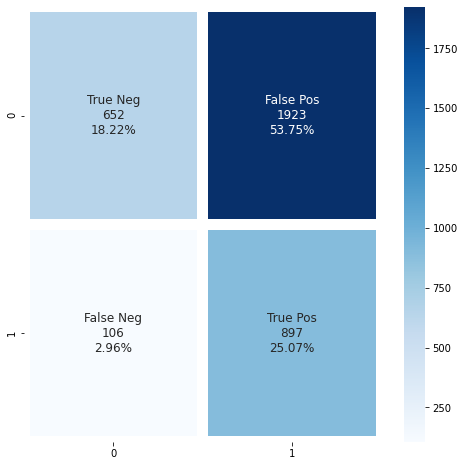

In [17]:
confusion_matrix_plot(y_test, y_pred_heroku)

In [18]:
station_objs_precison, station_avg_precison = verify_success_per_station_per_objective(df_heroku, y_test, y_pred_heroku, 1)

/home/hrkbaltazar/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
station_objs_precison[:5]

,station,Object of search,precision
13,city-of-london,Offensive weapons,0.160000
14,city-of-london,Article for use in theft,0.166667
1,nottinghamshire,Offensive weapons,0.208333
10,durham,Game or poaching equipment,0.250000
19,cambridgeshire,Controlled drugs,0.250000


In [20]:
station_avg_precison

,station,precision
3,cambridgeshire,0.250000
2,city-of-london,0.265550
0,nottinghamshire,0.279507
1,durham,0.554795


In [21]:
problematic_stations_g, good_stations_g, ignored_stations_g = verify_no_discrimination(df_heroku, y_test, y_pred_heroku, 'Gender', 30)

Gender
Global rates: {'Male': 0.31703531237873495, 'Female': 0.3056768558951965}
Num problematic departments: 1
Num good departments: 2
avg diff: 0.06600889096543242
Departments analysed: 3


In [22]:
print("Expected max diff between Genders in each station")
for i in problematic_stations_g[0:5]:
    print("\n", i[0],": ", round(i[1]*100,2),"%")
    for u in i[2]:
        print(u, round(i[2][u]*100,2))

Expected max diff between Genders in each station

 nottinghamshire :  6.6 %
Male 28.38
Female 21.78


In [23]:
problematic_stations_e, good_stations_e, ignored_stations_e = verify_no_discrimination(df_heroku, y_test, y_pred_heroku, 'Officer-defined ethnicity', 30)

Officer-defined ethnicity
Global rates: {'White': 0.3619806488332385, 'Black': 0.26939655172413796, 'Asian': 0.22524752475247525, 'Mixed': 0.2246376811594203, 'Other': 0.24561403508771928}
Num problematic departments: 2
Num good departments: 0
avg diff: 0.08756169972319403
Departments analysed: 2


In [24]:
print("Expected max diff between Ethnicties in each station")
for i in problematic_stations_e[0:5]:
    print("\n", i[0],": ", round(i[1]*100,2),"%")
    for u in i[2]:
        print(u, round(i[2][u]*100,2))

Expected max diff between Ethnicties in each station

 nottinghamshire :  7.57 %
White 30.03
Black 26.55
Asian 23.83
Mixed 22.46

 city-of-london :  9.94 %
White 30.05
Black 27.0
Asian 20.11
Other 20.51


## Predict on new data using imported model  <a class="anchor" id="2"></a>

In [25]:
# load new model to test on the new data
with open('columns.json', 'r') as fh:
    columns = json.load(fh)
with open('dtypes.pickle', 'rb') as fh:
    dtypes = joblib.load(fh)
with open('pipeline.pickle', 'rb') as fh:
    pipeline_test = joblib.load(fh)

In [26]:
cols_to_predict = ['Type','Part of a policing operation', 'Legislation',
                  'Object of search', 'station', 'hour', 'month', 'day_of_week', 'cluster'] 
#'Gender', 'Officer-defined ethnicity', 'Age range',
df = df_heroku[cols_to_predict].copy()

In [27]:
# new model Predicted Outcomes for new data
y_pred_new_model = pipeline_test.predict(df)

/home/hrkbaltazar/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


In [28]:
true_threshold  = 0.228
y_pred_new_model_threshold = np.array(list(map(lambda x: 1 if x > true_threshold else 0, y_pred_new_model)))

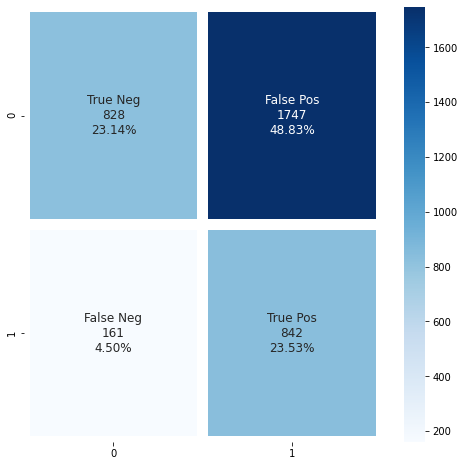

In [29]:
confusion_matrix_plot(y_test, y_pred_new_model_threshold)

In [30]:
station_objs_precison, station_avg_precison = verify_success_per_station_per_objective(df_heroku, y_test, y_pred_heroku, 30)

/home/hrkbaltazar/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
station_objs_precison[:5]

,station,Object of search,precision
9,city-of-london,Offensive weapons,0.160000
10,city-of-london,Article for use in theft,0.166667
1,nottinghamshire,Offensive weapons,0.208333
11,city-of-london,Stolen goods,0.253247
6,durham,Article for use in theft,0.271605


In [32]:
station_avg_precison[:5]

,station,precision
3,cambridgeshire,0.250000
2,city-of-london,0.265550
0,nottinghamshire,0.279507
1,durham,0.554795


In [33]:
problematic_stations, good_stations, ignored_stations = verify_no_discrimination(df_heroku, y_test, y_pred_new_model_threshold, 'Officer-defined ethnicity', 30)

Officer-defined ethnicity
Global rates: {'White': 0.37032418952618457, 'Black': 0.2694063926940639, 'Asian': 0.23333333333333334, 'Mixed': 0.22627737226277372, 'Other': 0.3}
Num problematic departments: 2
Num good departments: 0
avg diff: 0.09635900876860244
Departments analysed: 2


In [34]:
problematic_stations, good_stations, ignored_stations = verify_no_discrimination(df_heroku, y_test, y_pred_new_model_threshold, 'Gender', 30)

Gender
Global rates: {'Male': 0.3256010122311261, 'Female': 0.29411764705882354}
Num problematic departments: 2
Num good departments: 1
avg diff: 0.09268530958791217
Departments analysed: 3


In [35]:
print(classification_report(y_test, y_pred_new_model_threshold))

              precision    recall  f1-score   support

           0       0.84      0.32      0.46      2575
           1       0.33      0.84      0.47      1003

    accuracy                           0.47      3578
   macro avg       0.58      0.58      0.47      3578
weighted avg       0.69      0.47      0.47      3578



| Requirements |   Expected   | Reality |
|-------------------|--------|--------| 
| global discrimination (gender) (max 5%) |   0.12  | 0.06
| global discrimination (ethnicity) (max 5%) |  0.12  | 0.08

## Train a model with the new data  <a class="anchor" id="3"></a>

In [36]:
# # new data True Outcomes
# y_test = df_new_clean.outcome.values.astype(bool).astype(int) 
# df_heroku['target'] = y_test

# with open('dtypes_pre_process.pickle', 'rb') as fh:
#     dtypes_pre = pickle.load(fh)

# df_heroku['Self-defined ethnicity'] = ''
# df_heroku['Outcome'] = ''
# df_heroku['Outcome linked to object of search'] = ''
# df_heroku['Removal of more than just outer clothing'] = ''

# df_heroku = df_heroku.astype(dtypes_pre)

# cols_to_predict = ['Type','Part of a policing operation','Gender', 'Officer-defined ethnicity', 'Age range', 'Legislation',
#                   'Object of search', 'station', 'hour', 'month', 'day_of_week', 'cluster', 'target']

# df_clean = df_heroku[cols_to_predict].copy()

In [37]:
# # Exclude 'Age range', 'Self-defined ethnicity', 'observation_id','Removal of more than just outer clothing', 'Latitude'/'Longitude'
# # 'Gender', 'Officer-defined ethnicity'
# all_features = ['station', 
#                 'Type',
#                 'Part of a policing operation',
#                 'Object of search', 'Legislation', 
#                 'day_of_week', 
#                 'hour', 
#                 'month', 
#                 'cluster']
# numerical_features = ['hour', 'month']
# categorical_features = [ 'Object of search', 
#                         'Legislation', 
#                         'Type', 
#                         'Part of a policing operation', 
#                         'station', 
#                         'day_of_week','cluster']
# #categorical_features2 = ['cluster']
# target = 'target'

In [38]:
# df_train, df_test = train_test_split(df_clean, test_size=0.2, random_state=42, stratify=df_clean[target])

# X_train = df_train[all_features]
# y_train = df_train[target]

# X_test = df_test[all_features]
# y_test = df_test[target] 

In [39]:
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])#MyLEncoder())])  ### # 

# # categorical_transformer2 = Pipeline(steps=[
# #     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
# #     ('onehot', MyLEncoder())])  ### # 

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)]
#         #('cat2', categorical_transformer2, categorical_features2)]
# )

# pipeline = make_pipeline(
#     preprocessor,
#     #xgboost.XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=4)
#     xgboost.XGBRegressor(random_state=42)
#     #RandomForestClassifier(max_depth=10, class_weight="balanced", random_state=42, n_jobs=-1),
# )

# pipeline.fit(X_train, y_train)

# y_pred = pipeline.predict(X_test)
# y_pred_train = pipeline.predict(X_train)

In [40]:
# roc_curve_plot(y_test, y_pred)

In [41]:
# categorical_encode_step = pipeline.named_steps['columntransformer'].named_transformers_['cat'].named_steps['onehot']
# onehot_columns = categorical_encode_step.get_feature_names(input_features=categorical_features)

# xgb_regressor_step = pipeline.named_steps['xgbregressor']
# importances = pd.Series(data=xgb_regressor_step.feature_importances_, index = np.array(numerical_features + list(onehot_columns)))
# indices = np.argsort(importances)[::-1]

# print("Feature ranking:")
# for f in range(10):
#     feature_name = importances.index[indices[f]]
    
#     print(f"{f+1}. {feature_name} ({importances[indices[f]]})")

# Comparing old to new data

In [42]:
df_old['Part of a policing operation'].value_counts(normalize=True)

False    0.947314
True     0.052686
Name: Part of a policing operation, dtype: float64

In [43]:
df_heroku['Part of a policing operation'].value_counts(normalize=True)

False    0.749581
True     0.250419
Name: Part of a policing operation, dtype: float64

In [44]:
stations = ['nottinghamshire', 'city-of-london','durham','cambridgeshire']
for s in stations:
    df_ = df_old[df_old.station == s]
    total = df_.shape[0]
    suc = df_[df_.target == 1].shape[0]
    print(s, suc/total)

nottinghamshire 0.2552289429055964
city-of-london 0.27857343442853133
durham 0.35753575357535755
cambridgeshire 0.1806375442739079


In [46]:
# new data True Outcomes
y_test = df_new_clean.outcome.values.astype(bool).astype(int) 
df_heroku['target'] = y_test

for s in stations:
    df_ = df_heroku[df_heroku.station == s]
    total = df_.shape[0]
    suc = df_[df_.target == 1].shape[0]
    print(s, suc/total)

nottinghamshire 0.24298111281265952
city-of-london 0.24242424242424243
durham 0.5547945205479452
cambridgeshire 0.15384615384615385
